In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.notebook import tqdm
from CycleGAN_utils import *
from CycleGAN_models import *
import os
import numpy as np
import math
import itertools
import datetime
import time
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F


epoch = 0
n_epochs = 51
batch_size = 1
lr=0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 50
n_cpu = 8
img_height = 224
img_width = 224
channels = 1
sample_interval = 100
checkpoint_interval = 25
n_residual_blocks = 9
lambda_cyc = 10
lambda_id = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = torch.load("../datasets/224dataset.pt")

dataset = [sample for sample in dataset if sample != None]

NC = []
AD = []
for data in dataset:
    if data[1] == 0:
        NC.append(data)
    else:
        AD.append(data)
        
        
def process_gan(dataset, s):
    output = []
    dataset = [sample[0] for sample in dataset]
    for sample in dataset:
        sample = sample[s][0]
        sample /= torch.max(sample)
        output.append(torch.unsqueeze(sample, 0))
    return output

        
NCgan1 = process_gan(NC, 0)
NCgan2 = process_gan(NC, 1)
NCgan3 = process_gan(NC, 2)

ADgan1 = process_gan(AD, 0)
ADgan2 = process_gan(AD, 1)
ADgan3 = process_gan(AD, 2)

gan1 = []
for i in range(len(ADgan1)):
    gan1.append({"A": NCgan1[i], "B": ADgan1[i]})

gan2 = []
for i in range(len(ADgan2)):
    gan2.append({"A": NCgan2[i], "B": ADgan2[i]})
    
gan3 = []
for i in range(len(ADgan3)):
    gan3.append({"A": NCgan3[i], "B": ADgan3[i]})

batch_size = 1
dataloader1 = DataLoader(gan1, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader2 = DataLoader(gan2, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader3 = DataLoader(gan3, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
G_losses = []
D_losses = []
        
def sample_images(batches_done, dataloader):
    """Saves a generated sample from the test set"""
    imgs = next(iter(dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)

    real_A = make_grid(real_A, nrow=4, normalize=True)
    real_B = make_grid(real_B, nrow=4, normalize=True)
    fake_A = make_grid(fake_A, nrow=4, normalize=True)
    fake_B = make_grid(fake_B, nrow=4, normalize=True)

    image_grid = torch.stack((real_A, fake_B, real_B, fake_A), 0)
    save_image(image_grid, "ganimages/%s/%s.png" % (dataset_name, batches_done), normalize=False)
    
def train_gan(dataloader, epoch):
    prev_time = time.time()
    for epoch in range(epoch, n_epochs):
        for i, batch in enumerate(dataloader):

            # Set model input
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))

            # Adversarial ground truths
            valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
            fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

            # ------------------
            #  Train Generators
            # ------------------

            G_AB.train()
            G_BA.train()

            optimizer_G.zero_grad()


            # Identity loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)

            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN loss
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle loss
            recov_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total loss
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
                
            loss_G.backward()
            optimizer_G.step()

            # -----------------------
            #  Train Discriminator A
            # -----------------------
           
            optimizer_D_A.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_A(real_A), valid)
            # Fake loss (on batch of previously generated samples)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
            # Total loss
            loss_D_A = (loss_real + loss_fake) / 2

            loss_D_A.backward()
            optimizer_D_A.step()

            # -----------------------
            #  Train Discriminator B
            # -----------------------

            optimizer_D_B.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_B(real_B), valid)
            # Fake loss (on batch of previously generated samples)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2

            loss_D_B.backward()
            optimizer_D_B.step()

            loss_D = (loss_D_A + loss_D_B) / 2

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(dataloader) + i
            batches_left = n_epochs * len(dataloader) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()
            
            if i % 100 == 0:
            
                print(
                    "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                    % (
                        epoch,
                        n_epochs,
                        i,
                        len(dataloader),
                        loss_D.item(),
                        loss_G.item(),
                        loss_GAN.item(),
                        loss_cycle.item(),
                        loss_identity.item(),
                        time_left,
                    )
                )

            # If at sample interval save image
            if batches_done % sample_interval == 0:
                sample_images(batches_done, dataloader)
                
            
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())
            
            
        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

        if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
            # Save model checkpoints
            torch.save(G_AB.state_dict(), "saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch))
            torch.save(G_BA.state_dict(), "saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch))
            torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (dataset_name, epoch))
            torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (dataset_name, epoch))

    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [4]:
input_shape = (channels, img_height, img_width)

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, n_residual_blocks).cuda()
G_BA = GeneratorResNet(input_shape, n_residual_blocks).cuda()
D_A = Discriminator(input_shape).cuda()
D_B = Discriminator(input_shape).cuda()

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

Tensor = torch.cuda.FloatTensor

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Losses
criterion_GAN = torch.nn.MSELoss().cuda()
criterion_cycle = torch.nn.L1Loss().cuda()
criterion_identity = torch.nn.L1Loss().cuda()


if epoch != 0:

    G_AB.load_state_dict(torch.load("saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch)))
    G_BA.load_state_dict(torch.load("saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch)))
    D_A.load_state_dict(torch.load("saved_models/%s/D_A_%d.pth" % (dataset_name, epoch)))
    D_B.load_state_dict(torch.load("saved_models/%s/D_B_%d.pth" % (dataset_name, epoch)))
else:

    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)

In [5]:
# epoch = 0
# dataset_name = '224CycleGAN1'
# os.makedirs("ganimages/%s" % dataset_name, exist_ok=True)
# os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

# train_gan(dataloader1, epoch)

In [6]:
# epoch = 0
# dataset_name = '224CycleGAN2'
# os.makedirs("ganimages/%s" % dataset_name, exist_ok=True)
# os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

# train_gan(dataloader2, epoch)

[Epoch 0/51] [Batch 0/476] [D loss: 1.808080] [G loss: 11.352324, adv: 2.453085, cycle: 0.615865, identity: 0.548117] ETA: 5:21:07.200894
[Epoch 0/51] [Batch 100/476] [D loss: 0.231213] [G loss: 1.935448, adv: 0.549290, cycle: 0.096912, identity: 0.083407] ETA: 2:04:12.809910
[Epoch 0/51] [Batch 200/476] [D loss: 0.199476] [G loss: 1.878462, adv: 0.728786, cycle: 0.071792, identity: 0.086351] ETA: 2:05:38.083194
[Epoch 0/51] [Batch 300/476] [D loss: 0.277035] [G loss: 1.276387, adv: 0.436343, cycle: 0.052765, identity: 0.062479] ETA: 2:04:27.199551
[Epoch 0/51] [Batch 400/476] [D loss: 0.262154] [G loss: 1.472710, adv: 0.602391, cycle: 0.058835, identity: 0.056395] ETA: 2:34:58.953962
[Epoch 1/51] [Batch 0/476] [D loss: 0.234816] [G loss: 1.125616, adv: 0.365015, cycle: 0.053618, identity: 0.044885] ETA: 4:34:50.683842
[Epoch 1/51] [Batch 100/476] [D loss: 0.141460] [G loss: 1.715423, adv: 0.971555, cycle: 0.047523, identity: 0.053728] ETA: 2:04:58.065305
[Epoch 1/51] [Batch 200/476] [

[Epoch 12/51] [Batch 0/476] [D loss: 0.199032] [G loss: 0.763189, adv: 0.350826, cycle: 0.026401, identity: 0.029670] ETA: 2:58:18.940441
[Epoch 12/51] [Batch 100/476] [D loss: 0.235158] [G loss: 1.399800, adv: 0.635200, cycle: 0.053339, identity: 0.046243] ETA: 1:37:42.577438
[Epoch 12/51] [Batch 200/476] [D loss: 0.317604] [G loss: 0.823813, adv: 0.231317, cycle: 0.038689, identity: 0.041122] ETA: 1:37:17.178985
[Epoch 12/51] [Batch 300/476] [D loss: 0.086125] [G loss: 1.085543, adv: 0.609343, cycle: 0.032841, identity: 0.029558] ETA: 1:34:19.139179
[Epoch 12/51] [Batch 400/476] [D loss: 0.226094] [G loss: 0.763605, adv: 0.337320, cycle: 0.028467, identity: 0.028324] ETA: 1:36:51.474080
[Epoch 13/51] [Batch 0/476] [D loss: 0.147136] [G loss: 0.791497, adv: 0.363829, cycle: 0.028654, identity: 0.028226] ETA: 2:54:24.335526
[Epoch 13/51] [Batch 100/476] [D loss: 0.252798] [G loss: 1.433631, adv: 0.641600, cycle: 0.053460, identity: 0.051487] ETA: 1:35:35.431641
[Epoch 13/51] [Batch 200

[Epoch 23/51] [Batch 400/476] [D loss: 0.217785] [G loss: 1.255351, adv: 0.369913, cycle: 0.060538, identity: 0.056011] ETA: 1:08:42.743683
[Epoch 24/51] [Batch 0/476] [D loss: 0.129457] [G loss: 1.550289, adv: 0.658451, cycle: 0.060425, identity: 0.057518] ETA: 1:59:55.271579
[Epoch 24/51] [Batch 100/476] [D loss: 0.174636] [G loss: 0.998666, adv: 0.382239, cycle: 0.040648, identity: 0.041989] ETA: 1:13:55.717388
[Epoch 24/51] [Batch 200/476] [D loss: 0.251075] [G loss: 1.096492, adv: 0.644293, cycle: 0.029995, identity: 0.030450] ETA: 1:15:25.148199
[Epoch 24/51] [Batch 300/476] [D loss: 0.116612] [G loss: 1.734406, adv: 0.956461, cycle: 0.053433, identity: 0.048724] ETA: 1:12:52.118717
[Epoch 24/51] [Batch 400/476] [D loss: 0.103835] [G loss: 1.243263, adv: 0.790691, cycle: 0.030399, identity: 0.029717] ETA: 1:15:37.754088
[Epoch 25/51] [Batch 0/476] [D loss: 0.089416] [G loss: 1.200074, adv: 0.622990, cycle: 0.039166, identity: 0.037084] ETA: 2:04:01.175398
[Epoch 25/51] [Batch 100

[Epoch 35/51] [Batch 300/476] [D loss: 0.062390] [G loss: 1.196762, adv: 0.708844, cycle: 0.033251, identity: 0.031081] ETA: 0:38:54.093591
[Epoch 35/51] [Batch 400/476] [D loss: 0.142146] [G loss: 0.976547, adv: 0.247637, cycle: 0.051886, identity: 0.042009] ETA: 0:38:17.921249
[Epoch 36/51] [Batch 0/476] [D loss: 0.067984] [G loss: 1.551296, adv: 0.707087, cycle: 0.057606, identity: 0.053630] ETA: 1:06:19.078388
[Epoch 36/51] [Batch 100/476] [D loss: 0.162543] [G loss: 1.547662, adv: 0.989604, cycle: 0.036703, identity: 0.038206] ETA: 0:37:35.046997
[Epoch 36/51] [Batch 200/476] [D loss: 0.202071] [G loss: 1.103562, adv: 0.593632, cycle: 0.031878, identity: 0.038229] ETA: 0:36:41.865664
[Epoch 36/51] [Batch 300/476] [D loss: 0.038834] [G loss: 1.157582, adv: 0.709255, cycle: 0.031295, identity: 0.027075] ETA: 0:36:21.216402
[Epoch 36/51] [Batch 400/476] [D loss: 0.098968] [G loss: 1.425502, adv: 0.689261, cycle: 0.052681, identity: 0.041885] ETA: 0:35:56.291757
[Epoch 37/51] [Batch 0

[Epoch 47/51] [Batch 200/476] [D loss: 0.113313] [G loss: 1.216030, adv: 0.669288, cycle: 0.038195, identity: 0.032958] ETA: 0:09:17.694134
[Epoch 47/51] [Batch 300/476] [D loss: 0.050548] [G loss: 1.238013, adv: 0.788235, cycle: 0.030470, identity: 0.029015] ETA: 0:08:36.616155
[Epoch 47/51] [Batch 400/476] [D loss: 0.063344] [G loss: 1.574782, adv: 0.814658, cycle: 0.049558, identity: 0.052908] ETA: 0:08:03.479797
[Epoch 48/51] [Batch 0/476] [D loss: 0.074013] [G loss: 1.204886, adv: 0.622937, cycle: 0.038453, identity: 0.039483] ETA: 0:13:22.646021
[Epoch 48/51] [Batch 100/476] [D loss: 0.082867] [G loss: 1.129058, adv: 0.622297, cycle: 0.033590, identity: 0.034172] ETA: 0:07:04.296593
[Epoch 48/51] [Batch 200/476] [D loss: 0.194970] [G loss: 1.016443, adv: 0.508455, cycle: 0.033674, identity: 0.034249] ETA: 0:06:30.437635
[Epoch 48/51] [Batch 300/476] [D loss: 0.132115] [G loss: 1.215285, adv: 0.732144, cycle: 0.030881, identity: 0.034865] ETA: 0:06:09.436523
[Epoch 48/51] [Batch 4

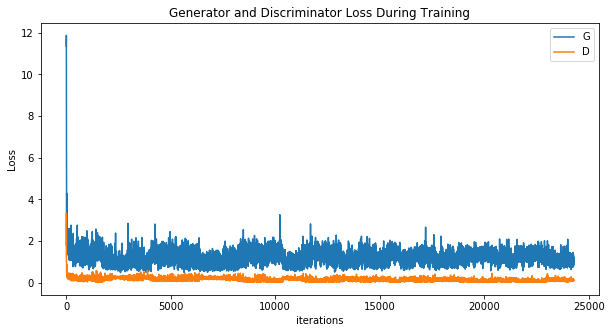

In [7]:
epoch = 0
dataset_name = '224CycleGAN3'
os.makedirs("ganimages/%s" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

train_gan(dataloader3, epoch)